# Mitigation of seasonal errors

Measurement errors related to variable illumination conditions during different season can severely bias the inverted time series. We have already explored weighting as a way to reduce the impact of erroneous measurements. In this notebook, we show two alternative mitigation strategies: regular sampling and same-season pairing

## Regular sampling
We start by creating a network of pairwise measurements as shown in the previous notebooks. For our synthetic dataset, we choose a regular 3 month sampling interval for the dates and add errors depending on the temporal baseline between reference and secondary images.

Number of image pairs: 190
Number of groups in network: 1


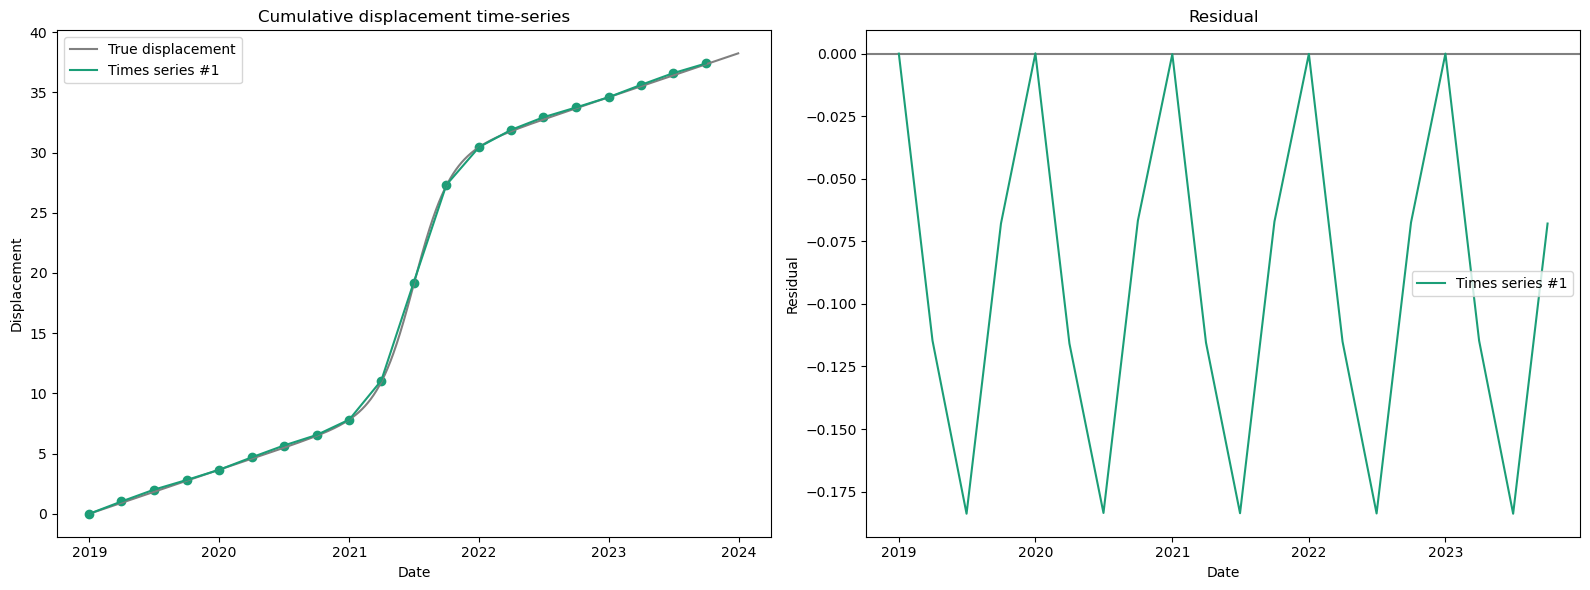

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from itertools import combinations
import random

#import functions for time-series inversion from relevant python script
import timeseries_inversion as inv

#create an artificial displacement signal (analog to previous notebook)
start_date = datetime.strptime('01/01/2019', '%d/%m/%Y')
end_date = datetime.strptime('31/12/2023', '%d/%m/%Y')

dr = pd.date_range(start=start_date, end=end_date, freq='D')

#create synthetic cumulative displacement original_signal
#here: sigmoid + linear function
x = np.arange(0, len(dr), 1)
y = 0.01 * x + 20 / (1 + np.exp(-0.02 * (np.arange(len(dr)) - len(dr)/2)))
original_signal = pd.DataFrame({'date': dr, 'disp': y})

sample_dates = pd.date_range(start=start_date, end=end_date, freq='3MS')

date_combinations = list(combinations(sample_dates, 2))
network = pd.DataFrame(date_combinations, columns=['date0', 'date1'])

#reuse original fully connected network and add seasonal error
network['disp'] = network.apply(lambda row: inv.find_dsoll(row, original_signal), axis = 1)
dt = (network.date1 - network.date0).dt.days
dt_rad = (dt / (365.25/2)) * ( np.pi)
error = np.sin(dt_rad) * 15
network['disp'] = network.disp + error
ts_regular = inv.run_inversion(network)
inv.plot_timeseries(ts_regular, original_signal)

In this regular scenario, the residual of the inverted time series to the original signal is very small, because positive and negative errors cancel each other out during the inversion. Having such regularly spaced acquisitions is, however, rarely the case, because clouds or snow cover can make scenes unusable for correlation. Therefore, let's create a more realistic scenario: in our hypothetical study area, the rainy season is during April so there are no cloud-free images available during that time: 

Number of image pairs: 105
Number of groups in network: 1


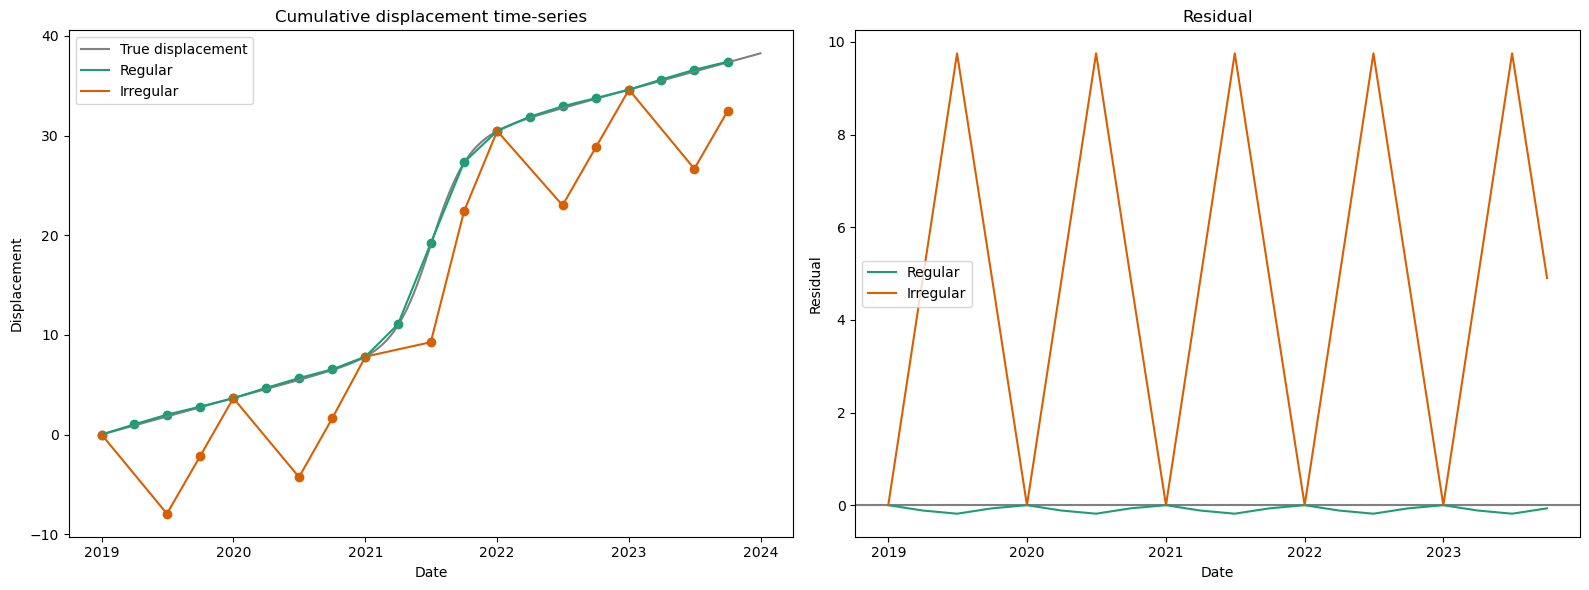

In [2]:
#removing all April scenes
sample_dates = sample_dates[sample_dates.month != 4]

date_combinations = list(combinations(sample_dates, 2))
network2 = pd.DataFrame(date_combinations, columns=['date0', 'date1'])

#reuse original fully connected network and add seasonal error
network2['disp'] = network2.apply(lambda row: inv.find_dsoll(row, original_signal), axis = 1)
dt = (network2.date1 - network2.date0).dt.days
dt_rad = (dt / (365.25/2)) * ( np.pi)
error = np.sin(dt_rad) * 15
network2['disp'] = network2.disp + error
ts_irregular = inv.run_inversion(network2)
inv.plot_timeseries([ts_regular, ts_irregular], original_signal, legend = ["Regular", "Irregular"])

With the missing scenes in April, the seasonal bias in the inverted time timeseries becomes very strong as the averaging effect is lost. In this case, it can help to apply a second strategy to mitigate the seasonal bias, namely restricting the network to same season pairs only.

## Same-season pairing
We are going to reuse our more realistic example with missing scenes during the rainy period and match the remaining acquisitions based on their temporal baseline. Secondary acquisitions have to be in a +/- day threshold from the reference + any multiples of years:

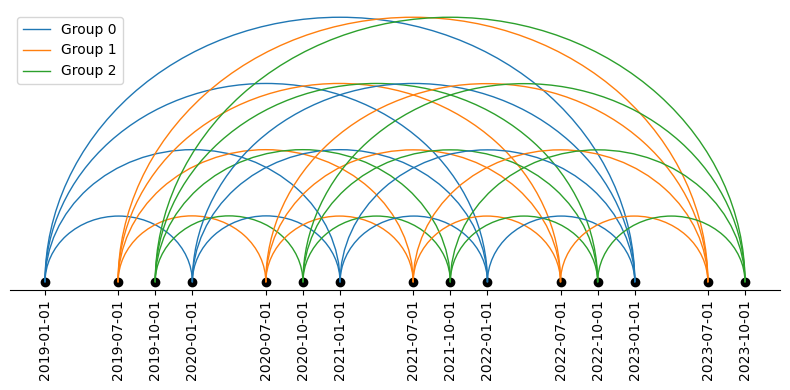

In [3]:
#subset network by temporal baseline to only keep same season pairs

dt_rad_year = (dt/365) * ( np.pi) #sine will have two year wavelength
season_daydiff = 15 #season_daydiff determines the day threshold +/- when two images are still considered to be aquired in a common season
network_sameseason = network2.loc[abs(np.sin(dt_rad_year)) <= (season_daydiff / 365.25) * ( np.pi)]

inv.plot_network(network_sameseason)

Now in this network, January scenes have only been paired with other January scenens, July with July and October with October. These connections should have lowest seasonal errors, so the bias on the inverted time series is reduced. Because the network is, however, disconnected due to the sampling strategy, the inversion needs to be solved with a regularization term to avoid artifacts:

Number of image pairs: 30
Number of groups in network: 3
Solving the inversion including a regularization term ...
Number of image pairs: 105
Number of groups in network: 1
Solving the inversion including a regularization term ...


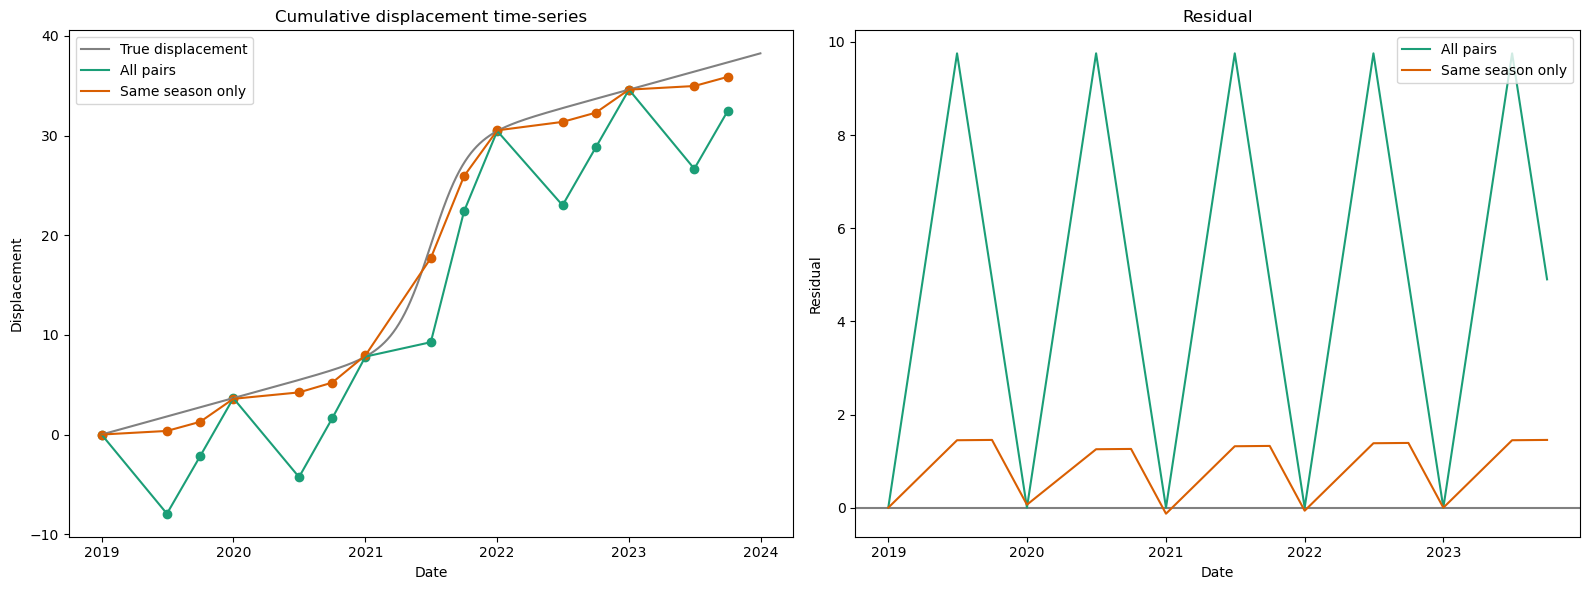

In [4]:
ts_sameseason = inv.run_inversion(network_sameseason, regu = True)
ts_all = inv.run_inversion(network2, regu = True)
inv.plot_timeseries([ts_all, ts_sameseason], original_signal, legend = ["All pairs", "Same season only"])